In [1]:
import pandas as pd
from itertools import cycle
import gpflow
import numpy as np
from gpflow.utilities import print_summary, positive
from gpflow.ci_utils import ci_niter
from gpflow.optimizers import NaturalGradient
from gpflow import set_trainable
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

tfd = tfp.distributions
np.random.seed(1234)

sns.set(style="white")

gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_summary_fmt("notebook")


In [2]:
print("The GPflow version is {0}".format(gpflow.__version__))
print("The tensorflow version is {0}".format(tf.__version__))
print("The tensorflow-probability version is {0}".format(tfp.__version__))

The GPflow version is 2.1.2
The tensorflow version is 2.3.1
The tensorflow-probability version is 0.11.1


In [3]:
# When run in my desktop
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

## Old Methods: Save them here

## Results Overview <a id='top'></a>

1. [Load Datasets US](#load_data)
2. [Explore the Google Mobility Dataset](#mobility)
3. [Merge the Datasets](#merge)
4. [Create Dataset for Training](#training)
5. [Kernel and Mobility Data](#kernel)
6. [Variational Bayesian non-parametric inference for infectious disease models](#models)

We denote $y=(y_{i})^{N}$ as the number of daily COVID cases and $y\sim \mathcal{Pois}(\lambda)$, where $\lambda = exp(f(x))$ and $f(x) = \mathcal{GP}(0, K)$


| Model number |   Model   | Likelihood | Kernel | inducing points | within-sample RMSE ($n=139$) | out-of-sample RMSE ($n=21$) | $R^2$ | wisVAR | oosVAR | GPflow | 1st week frc$^1$ | 2nd week frc$^2$ | 3rd week frc$^3$ | whole test frc$^4$ | frc ratio$^5$ |
| :- | :- | :- | :- | :- | :-: | :-: | :-: | :-: | :-: | -: | :-: | :-: | :-: | :-: | :-: |
| [M1](#M1) | λ(t) = exp(f(t)) | Poisson | Matern 3/2 | 15 | 0.152 | 1.617 | 0.96 | 0.002 | 0.407 | SVGP | -14,391 | -31,254 | -40,487 | -28,710 | 45% |
| [M2](#M2) | λ(t) = β(t)S(t)I(t) = exp(f(t))S(t)I(t) | Poisson | Matern 3/2 | - | - | - | - | - | - | SVGP | - | - | - | - | - |
| [M3](#M3) | λ(t) = exp(f(S(t)I(t))) | Poisson | Matern 3/2 | 15 | 0.151 | 1.606 | 0.95 | 0.001 | 4.896 | SVGP | -31,211 | -59,416 | -52,855 | -47,827 | 75% |
| [M4](#M4) | λ(t) = exp(f(S(t)I(t) + Mobility Variables)) | Poisson | Matern 3/2 | 15 | 0.176 | 0.519 | 0.88 | 0.016 | 0.153 | SVGP | -7,609 | -670 | 7,497 | -261 | 1% |
| [M5](#M5) | λ(t) = exp(f(S(t)I(t) + Mobility Variables 7-day Smoothed)) | Poisson | Matern 3/2 | 15 | 0.182 | 0.544 | 0.90 | 0.011 | 0.182 | SVGP | -4,447 | 2,638 | 11,407 | 3,199 | 6% |
| [M6](#M6) | λ(t) = exp(f(S(t)I(t) + WORK + OTHER)) | Poisson | Matern 3/2 | 15 | 0.196 | 0.490 | 0.87 | 0.013 | 0.174 | SVGP | -7,528 | -260 | 7,531 | 85 | <1% |
| [M7](#M7) | λ(t) = exp(f(S(t)I(t) + HOME)) | Poisson | Matern 3/2 | 15 | 0.196 | 1.319 | 0.89 | 0.174 | 0.378 | SVGP | 5,984 | 20,201 | 34,247 | 20,144 | 33% |
| [M9](#M9) | λ(t) = exp(f(Mobility Variables)) | Poisson | Matern 3/2 | 15 | 0.285 | 1.677 | 0.77 | 0.016 | 0.010 | SVGP | -28,243 | -32,644 | -33,652 | -31,513 | 49% |
| [M10](#M10) | γ(t) = exp(f(I(t) + HOME)) | Poisson | Matern 3/2 | 15 | 0.142 | 3.635 | 0.27 | 0.001 | 0.382 | SVGP | 17,471 | -70,190 | 26,286 | -8,811 | - |
| [M11](#M11) | γ(t) = exp(f(I(t) + WORK + OTHER)) | Poisson | Matern 3/2 | 15 | 0.142 | 2.712 | 0.28 | 0.001 | 0.007 | SVGP | -5,835 | -105,370 | -17,217 | -42,807 | - |
| [M8](#M8) | λ(t) = exp(f(S(t)I(t) + WORK + OTHER)) | Poisson | Matern 3/2 | 15 | 0.240 | 0.989 | 0.74 | 0.043 | 0.123 | Multi-output SVGP (α) | -17,079 | -18,904 | 18,446 | 18,143 | 28% |
| [M8](#M8) | γ(t) = exp(f(I(t) + HOME)) | Poisson | Matern 3/2 | 15 | 0.154 | 2.70 | 0.2 | 0.005 | 0.009 | Multi-output SVGP (β) | -274 | 99,692 | 11,598 | 37,188 | - |


Negative values in the 4 forecast columns indicate that our model underestimates the actual daily cases; positive values indicate that the model overestimate the actual results.

1. forecast using dates 2020-07-07 to 2020-07-13
2. forecast using dates 2020-07-14 to 2020-07-20
3. forecast using dates 2020-07-21 to 2020-07-27
4. forecast using whole test set 2020-07-07 to 2020-07-27
5. forecast ratio for the whole test set = mean(frc diff/daily cases)

## Load Datasets US <a id='load_data'></a>

The second data come from microsoft [link](https://github.com/microsoft/Bing-COVID-19-Data). This set includes recovered, so we can calculate the number of infected, recovered and susceptible as a function of time. 

In [4]:
mobility_data = pd.read_csv("./Data/Google/Global_Mobility_Report.csv", encoding = "ISO-8859-1")
mobility_data["date"] = pd.to_datetime(mobility_data["date"], format='%d/%m/%Y')

c:\programdata\anaconda3\envs\hyperion\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# COVID Cases from Microsoft, includes Recovered and Infected
ms_covid = pd.read_csv("./Data/Microsoft/COVID_CASES.csv", encoding = "ISO-8859-1")
ms_covid["Updated"] = pd.to_datetime(ms_covid["Updated"], format='%m/%d/%Y')
ms_covid = ms_covid[(ms_covid.Country_Region=="United States") & (ms_covid.AdminRegion1.isnull())]
ms_covid = ms_covid.loc[:,["Updated", "Confirmed", "ConfirmedChange", "Deaths", "DeathsChange", "Recovered", "RecoveredChange"]]

Is the computation of the three states correct?

I = {Cumulative Confirmed (cases) - Cumulative Deaths - Cumulative Recovered}

S = 328mil (US pop) - I

In [6]:
# Create the 3 categories S, I, R for US data (UK does not include R)
ms_covid["I"] = ms_covid["Confirmed"] - ms_covid["Deaths"] - ms_covid["Recovered"]

ms_covid["S"] = 328000000 - ms_covid["I"]

# Create a time variable
# If we have a weekend then assign 0 or weekday 1
ms_covid["Date_number"] = ms_covid.Updated.dt.dayofyear - 20
ms_covid["WEEKDAY"] = 0
ms_covid.loc[ms_covid.Updated.dt.dayofweek < 5, "WEEKDAY"] = 1
ms_covid["WEEKDAY"] = ms_covid["WEEKDAY"]

In [7]:
# drop the last value because it looks wrong
ms_covid = ms_covid[:-1].copy()

In [8]:
# US
ms_covid["Confirmed"] = ms_covid["Confirmed"].astype("float64")
ms_covid["Date_number"] = ms_covid["Date_number"].astype("float64")
ms_covid["WEEKDAY"] = ms_covid["WEEKDAY"].astype("float64")
ms_covid.dtypes

Updated            datetime64[ns]
Confirmed                 float64
ConfirmedChange           float64
Deaths                    float64
DeathsChange              float64
Recovered                 float64
RecoveredChange           float64
I                         float64
S                         float64
Date_number               float64
WEEKDAY                   float64
dtype: object

[Back to Top](#top)

# Explore the Google Mobility Dataset <a id='mobility'></a>

From the Google Mobility data we keep only the general UK cases. We do not go down to LAD (lower administrative level).

We do the same for the US cases

In [9]:
mobility_data_us = mobility_data[(mobility_data.country_region=="United States") & (mobility_data.sub_region_1.isnull())]
mobility_data_us = mobility_data_us.iloc[:,7:].reset_index(drop=True) # keep only relevant columns
mobility_data_us.columns

Index(['date', 'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline'],
      dtype='object')

In [10]:
# transform the data to pct change
mobility_data_us[mobility_data_us.columns[1:]] = mobility_data_us[mobility_data_us.columns[1:]].apply(lambda x: x/100 + 1)

In [11]:
data_us = pd.DataFrame(mobility_data_us["date"])

Merge the Google mobility data to HOME, WORK, and OTHER, with the OTHER to include parks, transit, retail and grocery. 

In [12]:
data_us["HOME"] = mobility_data_us['residential_percent_change_from_baseline'].copy()
data_us["WORK"] = mobility_data_us['workplaces_percent_change_from_baseline'].copy()
data_us["OTHER"] = mobility_data_us.iloc[:,1:5].mean(axis=1)

[Back to Top](#top)

# Merge the Datasets <a id='merge'></a>

Merge the two datasets, the MS covid US and the Google mobility by date

In [13]:
final_data_us = ms_covid.merge(data_us, how='left', left_on='Updated', right_on='date') 
final_data_us.drop(["date"], axis=1, inplace=True)

In [14]:
# Clear NA rows
final_data_us = final_data_us.iloc[28:188,:].copy()

[Back to Top](#top)

## Create Dataset for Training <a id='training'></a>

In [15]:
final_data_us["SI"] = final_data_us.S*final_data_us.I

In [16]:
final_data_us.reset_index(drop=True, inplace=True)

final_data_us

,Updated,Confirmed,ConfirmedChange,Deaths,DeathsChange,Recovered,RecoveredChange,I,S,Date_number,WEEKDAY,HOME,WORK,OTHER,SI
0,2020-02-19,24.0,3.0,2.0,0.0,3.0,0.0,19.0,327999981.0,30.0,1.0,1.00,1.01,1.0275,6.232000e+09
1,2020-02-20,27.0,3.0,2.0,0.0,3.0,0.0,22.0,327999978.0,31.0,1.0,1.01,1.00,1.0125,7.216000e+09
2,2020-02-21,31.0,4.0,2.0,0.0,6.0,3.0,23.0,327999977.0,32.0,1.0,1.00,1.00,1.0125,7.543999e+09
3,2020-02-22,35.0,4.0,2.0,0.0,6.0,0.0,27.0,327999973.0,33.0,0.0,0.99,1.04,1.0950,8.855999e+09
4,2020-02-23,35.0,0.0,2.0,0.0,6.0,0.0,27.0,327999973.0,34.0,0.0,0.99,1.02,1.0950,8.855999e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,2020-07-23,3973169.0,70719.0,133151.0,1082.0,1226670.0,40913.0,2613348.0,325386652.0,185.0,1.0,1.11,0.63,1.0200,8.503486e+14
156,2020-07-24,4047529.0,74360.0,134301.0,1150.0,1252170.0,25500.0,2661058.0,325338942.0,186.0,1.0,1.11,0.63,1.0100,8.657458e+14
157,2020-07-25,4113473.0,65944.0,135286.0,985.0,1277437.0,25267.0,2700750.0,325299250.0,187.0,0.0,1.04,0.87,1.0875,8.785519e+14
158,2020-07-26,4172104.0,58631.0,135838.0,552.0,1296612.0,19175.0,2739654.0,325260346.0,188.0,0.0,1.03,0.84,1.0475,8.911008e+14


[Back to Top](#top)

# Variational Bayesian non-parametric inference for infectious disease models <a id='models'></a>

In this approach we follow Hensman and Kypraios paper. 

1. $\lambda(t)$ = exp($f$(t)); the GP model depends only on time
2. $\lambda(t)$ = $\beta(t)$S(t)I(t) with $\beta(t)$ = exp($f$(t)); the GP model allows the person to person infenction to be non-constant and time-varying
3. $\lambda(t)$ = exp($f$(S(t)I(t))); the GP model is a function of the product S(t)I(t)

In [17]:
def plot_prediction(X, Y, model, intg=0, X_test=None, Y_test=None, num_samples=20):
    fig, ax = plt.subplots(1, figsize=(15, 4))
    
    Xnew = np.linspace(X.min(axis=0) - 0.5, X.max(axis=0) + 0.5, 100)
    Ypred = model.predict_f_samples(Xnew, full_cov=True, num_samples=num_samples)
    mean, var = model.predict_f(Xnew)
    
    ax.plot(Xnew[:,intg], np.squeeze(np.exp(Ypred)).T, "C1", alpha=0.2)
    ax.plot(Xnew[:,intg], np.exp(mean), "-", c="C0")
    
    lo = (np.exp(mean) - 2 * tf.sqrt(np.exp(var))).numpy()
    hi = (np.exp(mean) + 2 * tf.sqrt(np.exp(var))).numpy()
    ax.fill_between(Xnew[:,intg], lo.flatten(), hi.flatten(), alpha=0.3)
    ax.plot(X[:,intg], Y, "o", c="C2", alpha=0.7, label="train")
    if (X_test is not None) and (Y_test is not None):
        ax.plot(X_test, Y_test, "o", c="C3", alpha=0.7, label="test")
        ax.legend()

In [18]:
def plot_model(Y, Y_mean, Y_var, intial_inducing_points=None, inducing_points_list=None, test=False, x_ind=0):
    fig, ax = plt.subplots(1, figsize=(15, 4))
    
    if test==False:
        X = final_data_us[["Updated"]][:split]
        
        z_points = [np.argmin(np.abs(X_train[:, x_ind]-x)) for i, x in enumerate(intial_inducing_points)]
        Z_dates = final_data_us.iloc[z_points, :]["Updated"]
        ax.plot(Z_dates, np.zeros_like(z_points), "k|", mew=4, c="green", label="Initial inducing locations")
        
        z_points = [np.argmin(np.abs(X_train[:, x_ind]-x)) for i, x in enumerate(inducing_points_list)]
        Z_dates = final_data_us.iloc[z_points, :]["Updated"]
        ax.plot(Z_dates, np.zeros_like(z_points), "k|", mew=4, label="Inducing locations")
    else:
        X = final_data_us[["Updated"]][split:]
    
    lo = (Y_mean - 2 * tf.sqrt(Y_var)).numpy()
    hi = (Y_mean + 2 * tf.sqrt(Y_var)).numpy()
    
    
    
    ax.plot(X, Y, "o", c="brown", label="Daily COVID cases")
    ax.plot(X, Y_mean, "-", c="blue", label="Average COVID prediction")
    ax.fill_between(X.to_numpy().flatten(), lo.flatten(), hi.flatten(), alpha=0.3, interpolate=True)


In [19]:
# Create inducing inputs for the Sparse VGP
# The initial inputs should be random to mitigate for performance bias
def inducing_points(data, size=15):
    if size>data.shape[0]:
        print("Inducing points should be less (or equal) of the data rows X.")
        
    np.random.seed(1234)

    for c in range(data.shape[1]):
            if c==0:
                ind = np.random.randint(data.shape[0], size=size)
                Z = data[ind, c]
            else:
                ind = np.random.randint(data.shape[0], size=size)
                Z_ = data[ind, c]
                Z = np.vstack((Z, Z_))
    return(Z)

In [20]:
# r2 score
def r_2(y, y_predict):
    y_bar = np.mean(y)
    SS_tot = np.sum((y-y_bar)**2)
    SS_reg = np.sum((y_predict-y_bar)**2)
    r_2 = SS_reg/SS_tot
    return(np.round(r_2, 2))

[Back to Top](#top)

### MODEL 1: <a id='M1'></a>

$\lambda(t)$ = exp($f$(t)); the GP model depends only on time

In [21]:
# Keep the mean and the variance
mean_y = final_data_us["ConfirmedChange"].to_numpy().mean()
std_y = final_data_us["ConfirmedChange"].to_numpy().std()

mean_r = final_data_us["RecoveredChange"].to_numpy().mean()
std_r = final_data_us["RecoveredChange"].to_numpy().std()

In [22]:
# Split the data into test and training sets
y = final_data_us["ConfirmedChange"].to_numpy()
X = final_data_us[["Date_number"]].to_numpy()


split = 139 # This leaves 3 weeks test set, in order to be able to check the forecast performance in 1 - 2 - 3 weeks.

y_train = y[:split]
y_test = y[split:]

X_train = X[:split]
X_test = X[split:]

y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))

X_train = X_train.reshape((-1,1))
X_test = X_test.reshape((-1,1))

In [23]:
# Create the kernel
MTRN = gpflow.kernels.Matern32()
k = MTRN

#SE = gpflow.kernels.SquaredExponential()
#LIN = gpflow.kernels.Linear()
#RQ = gpflow.kernels.RationalQuadratic()
#k = SE*LIN*RQ + gpflow.kernels.White(variance=3.0)

print_summary(k)

name,class,transform,prior,trainable,shape,dtype,value
Matern32.variance,Parameter,Softplus,,True,(),float64,1
Matern32.lengthscales,Parameter,Softplus,,True,(),float64,1


In [24]:
# Initialise the inducing points
Zinit = inducing_points(X_train, size=15)
Zinit = Zinit.reshape((-1, 1))

In [25]:
m1 = gpflow.models.SVGP(likelihood=gpflow.likelihoods.Poisson(), kernel=k, inducing_variable=Zinit, 
                       num_data=X_train.shape[0])

adam = tf.optimizers.Adam(0.01)


logf = []

for _ in range(ci_niter(1000)):
    adam.minimize(lambda:m1.training_loss((X_train, y_train)), m1.trainable_variables)
    #natgrad.minimize(lambda:m1.training_loss((X_train, y_train)), [(m1.q_mu, m1.q_sqrt)])   
    logf.append(m1.elbo(((X_train, y_train))))

In [26]:
print_summary(m1)

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,3.368994648141982
SVGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,8.064268377526885
SVGP.inducing_variable.Z,Parameter,Identity,,True,"(15, 1)",float64,[[78.6156179...
SVGP.q_mu,Parameter,Identity,,True,"(15, 1)",float64,[[5.60183054...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 15, 15)",float64,"[[[-1.27319849e-03, 0.00000000e+00, 0.00000000e+00..."


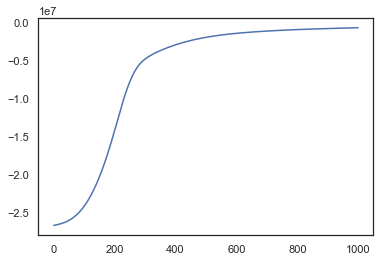

In [27]:
# ELBO
plt.plot(logf)

In [28]:
mean, var = m1.predict_f(X_train)

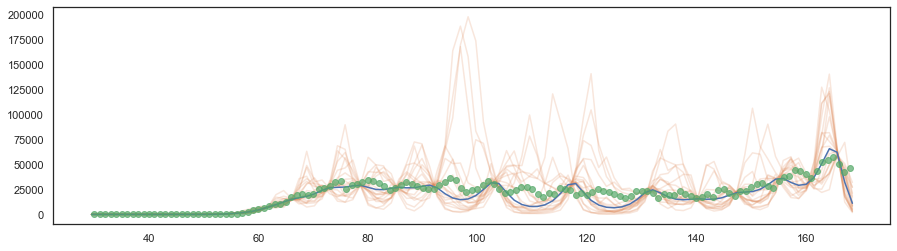

In [29]:
plot_prediction(X_train, y_train, m1, X_test=None, Y_test=None, num_samples=20)

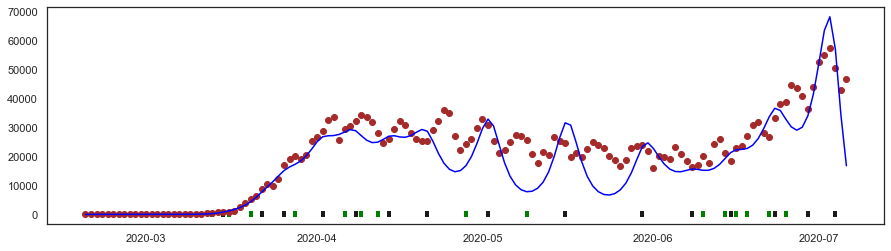

In [30]:
plot_model(y_train, np.exp(mean), np.exp(var), intial_inducing_points=list(Zinit[:,0]), inducing_points_list=list(m1.inducing_variable.Z.numpy()[:,0]))

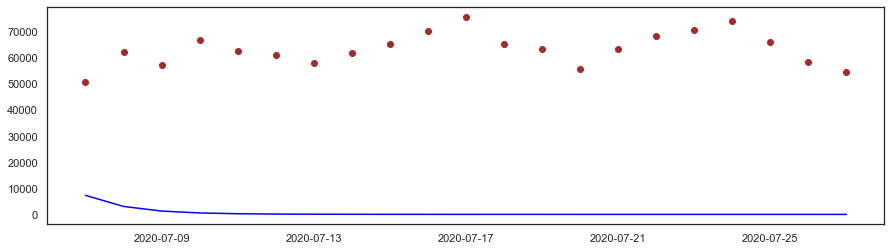

In [31]:
# The test US data are

mean_test, var_test = m1.predict_f(X_test)

plot_model(y_test, np.exp(mean_test), np.exp(var_test), test=True)

In [32]:
np.mean(var_test.numpy())

2.7863568100624456

In [33]:
wsRMSE = np.round(np.sqrt(np.mean((y_train - np.exp(mean))**2)), 3)
osRMSE = np.round(np.sqrt(np.mean((y_test - np.exp(mean_test))**2)), 3)
R_sq = r_2(y_train, np.exp(mean))
print("The within-sample (n={0}) RMSE is: {1} and the out-of-sample (n={2}) RMSE is: {3}. The R^2 is: {4}.".format(X_train.shape[0], wsRMSE, X_test.shape[0], osRMSE, R_sq))

The within-sample (n=139) RMSE is: 7139.953 and the out-of-sample (n=21) RMSE is: 63319.746. The R^2 is: 1.02.


In [34]:
# 7-days forecast (set 2020-07-07 to 2020-07-13)
week1f = np.round(np.mean(final_data_us["ConfirmedChange"].to_numpy()[split:split+7] - np.exp(mean_test)[:7]), 0)
# 14 days forecast (set 2020-07-14 to 2020-07-20)
week2f = np.round(np.mean(final_data_us["ConfirmedChange"].to_numpy()[split+7:split+14] - np.exp(mean_test)[7:14]), 0)
# 21 days forecast (set 2020-07-21 to 2020-07-27)
week3f = np.round(np.mean(final_data_us["ConfirmedChange"].to_numpy()[split+14:] - np.exp(mean_test)[14:]), 0)
# Whole forecat (set 2020-07-07 to 2020-07-27)
forecst = np.round(np.mean(final_data_us["ConfirmedChange"].to_numpy()[split:] - np.exp(mean_test)), 0)
# Difference of the forecast as a ratio of the daily cases (whole test set -- 21 days)
diff_ratio = np.round(np.mean((final_data_us["ConfirmedChange"].to_numpy()[split:] - np.exp(mean_test))/final_data_us["ConfirmedChange"].to_numpy()[split:]), 2)

print("The week1 forecast is: {0}, week2 is: {1}, week3 is {2}, whole test set: {3} and ratio {4}.".format(week1f, week2f, week3f, forecst, diff_ratio))

The week1 forecast is: 58128.0, week2 is: 65437.0, week3 is 65188.0, whole test set: 62918.0 and ratio 0.99.


[Back to Top](#top)

### MODEL 2: <a id='M2'></a>

$\lambda(t)$ = $\beta(t)$S(t)I(t) with $\beta(t)$ = exp($f(t)$); the GP model allows the person to person infenction to be non-constant and time-varying

In [36]:
p_likelihood = gpflow.likelihoods.Poisson()
p_likelihood.conditional_mean()

TypeError: conditional_mean() missing 1 required positional argument: 'F'

In [ ]:
p_likelihood = gpflow.likelihoods.Poisson()
p_likelihood.conditional_mean
# The test US data are
factors_SI = final_data_us.S[split:]*final_data_us.I[split:]
factors_SI = factors_SI.to_numpy()
factors_SI = preprocessing.scale(factors_SI)

plt.figure(figsize=(10,6))
plt.plot(y_test)
plt.plot(mean_test.numpy().reshape((-1,))*factors_SI)
plt.plot(mean_test.numpy().reshape((-1,))*factors_SI + 2 * np.sqrt(var_test.numpy().reshape((-1,)))*factors_SI, "C0", lw=0.5)
plt.plot(mean_test.numpy().reshape((-1,))*factors_SI - 2 * np.sqrt(var_test.numpy().reshape((-1,)))*factors_SI, "C0", lw=0.5)

[Back to Top](#top)

## Model 3 <a id='M3'></a>

$\lambda(t)$ = exp($f$(S(t)I(t)))

In [47]:
y = final_data_us["ConfirmedChange"].to_numpy()
X = final_data_us["SI"].to_numpy()


#y = preprocessing.scale(y)
X = preprocessing.scale(X)

split = 139

y_train = y[:split]
y_test = y[split:]

X_train = X[:split]
X_test = X[split:]

y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))

X_train = X_train.reshape((-1,1))
X_test = X_test.reshape((-1,1))

c:\programdata\anaconda3\envs\hyperion\lib\site-packages\sklearn\preprocessing\_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [48]:
MTRN = gpflow.kernels.Matern32()
k = MTRN

print_summary(k, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
Matern32.variance,Parameter,Softplus,,True,(),float64,1
Matern32.lengthscales,Parameter,Softplus,,True,(),float64,1


In [49]:
# Initialise the inducing points
Zinit = inducing_points(X_train, size=15)
Zinit = Zinit.reshape((-1, 1))

In [50]:
m3 = gpflow.models.SVGP(likelihood=gpflow.likelihoods.Poisson(), kernel=k, inducing_variable=Zinit, 
                       num_data=X_train.shape[0])

#natgrad = NaturalGradient(gamma=1.0)
adam = tf.optimizers.Adam(0.01)

#set_trainable(m3.q_mu, False)
#set_trainable(m3.q_sqrt, False)

logf = []

for _ in range(ci_niter(1000)):
    adam.minimize(lambda:m3.training_loss((X_train, y_train)), m3.trainable_variables)
    #natgrad.minimize(lambda:m3.training_loss((X_train, y_train)), [(m3.q_mu, m3.q_sqrt)])   
    logf.append(m3.elbo(((X_train, y_train))))

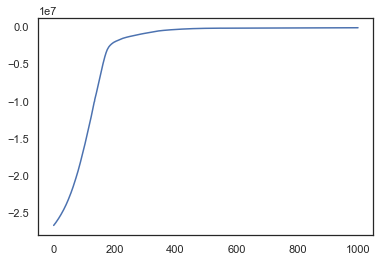

In [51]:
# ELBO
plt.plot(logf)

In [52]:
print_summary(m3, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,3.962727500940178
SVGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.7200341195428988
SVGP.inducing_variable.Z,Parameter,Identity,,True,"(15, 1)",float64,[[-1.56028762...
SVGP.q_mu,Parameter,Identity,,True,"(15, 1)",float64,[[2.8049473...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 15, 15)",float64,"[[[2.11119699e-02, 0.00000000e+00, 0.00000000e+00..."


In [53]:
mean, var = m3.predict_f(X_train)

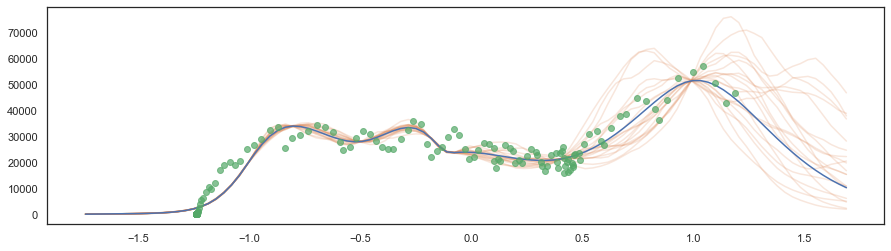

In [54]:
plot_prediction(X_train, y_train, m3, X_test=None, Y_test=None, num_samples=20)

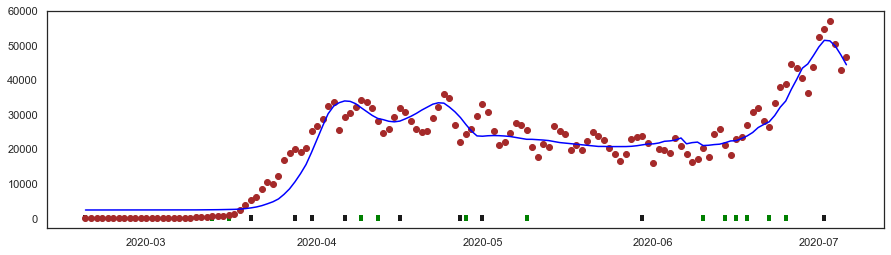

In [55]:
plot_model(y_train, np.exp(mean), np.exp(var), intial_inducing_points=list(Zinit[:,0]), inducing_points_list=list(m3.inducing_variable.Z.numpy()[:,0]))

In [56]:
np.mean(var.numpy())

0.0060630732320887835

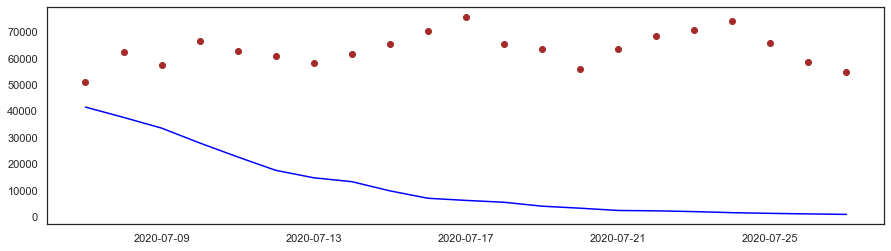

In [57]:
# The test US data are

mean_test, var_test = m3.predict_f(X_test)

plot_model(y_test, np.exp(mean_test), np.exp(var_test), test=True)

In [58]:
np.mean(var_test.numpy())

1.1750501207158615

In [59]:
wsRMSE = np.round(np.sqrt(np.mean((y_train - np.exp(mean))**2)), 3)
osRMSE = np.round(np.sqrt(np.mean((y_test - np.exp(mean_test))**2)), 3)
R_sq = r_2(y_train, np.exp(mean))
print("The within-sample (n={0}) RMSE is: {1} and the out-of-sample (n={2}) RMSE is: {3}. The R^2 is: {4}.".format(X_train.shape[0], wsRMSE, X_test.shape[0], osRMSE, R_sq))

The within-sample (n=139) RMSE is: 3816.233 and the out-of-sample (n=21) RMSE is: 53921.982. The R^2 is: 0.9.


In [60]:
# 7-days forecast (set 2020-07-07 to 2020-07-13)
week1f = np.round(np.mean(final_data_us["ConfirmedChange"].to_numpy()[split:split+7] -np.exp(mean_test)[:7]), 0)
# 14 days forecast (set 2020-07-14 to 2020-07-20)
week2f = np.round(np.mean(final_data_us["ConfirmedChange"].to_numpy()[split+7:split+14] - np.exp(mean_test)[7:14]), 0)
# 21 days forecast (set 2020-07-21 to 2020-07-27)
week3f = np.round(np.mean(final_data_us["ConfirmedChange"].to_numpy()[split+14:] - np.exp(mean_test)[14:]), 0)
# Whole forecat (set 2020-07-07 to 2020-07-27)
forecst = np.round(np.mean(final_data_us["ConfirmedChange"].to_numpy()[split:] - np.exp(mean_test)), 0)
# Difference of the forecast as a ratio of the daily cases (whole test set -- 21 days)
diff_ratio = np.round(np.mean((final_data_us["ConfirmedChange"].to_numpy()[split:] - np.exp(mean_test))/final_data_us["ConfirmedChange"].to_numpy()[split:]), 2)

print("The week1 forecast is: {0}, week2 is: {1}, week3 is {2}, whole test set: {3} and ratio {4}.".format(week1f, week2f, week3f, forecst, diff_ratio))

The week1 forecast is: 32009.0, week2 is: 58521.0, week3 is 63652.0, whole test set: 51394.0 and ratio 0.81.


[Back to Top](#top)

## Alternative method <a id='M4'></a>

$\lambda(t)$ = exp($f$(S(t)I(t) + WKDAY(t) + HOME(t) + WORK(t) + OTHER(t)))

In [61]:
y = final_data_us["ConfirmedChange"].to_numpy()
X = final_data_us[["SI", "WEEKDAY", "HOME", "WORK", "OTHER"]].to_numpy()


#y = preprocessing.scale(y)
X = preprocessing.scale(X)

split = 139

y_train = y[:split]
y_test = y[split:]

X_train = X[:split]
X_test = X[split:]

y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))

c:\programdata\anaconda3\envs\hyperion\lib\site-packages\sklearn\preprocessing\_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [62]:
MTRN = gpflow.kernels.Matern32()
k = MTRN

#SE = gpflow.kernels.SquaredExponential()
#LIN = gpflow.kernels.Linear()
#RQ = gpflow.kernels.RationalQuadratic()
#k = SE*LIN*RQ

print_summary(k, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
Matern32.variance,Parameter,Softplus,,True,(),float64,1
Matern32.lengthscales,Parameter,Softplus,,True,(),float64,1


In [63]:
# Initialise the inducing points
Zinit = inducing_points(X_train, size=15)
Zinit = Zinit.T

In [64]:
m4 = gpflow.models.SVGP(likelihood=gpflow.likelihoods.Poisson(), kernel=k, inducing_variable=Zinit, 
                       num_data=X_train.shape[0])

#natgrad = NaturalGradient(gamma=1.0)
adam = tf.optimizers.Adam(0.01)

#set_trainable(m4.q_mu, False)
#set_trainable(m4.q_sqrt, False)

logf = []

for _ in range(ci_niter(1000)):
    adam.minimize(lambda:m4.training_loss((X_train, y_train)), m4.trainable_variables)
    #natgrad.minimize(lambda:m4.training_loss((X_train, y_train)), [(m4.q_mu, m4.q_sqrt)])   
    logf.append(m4.elbo(((X_train, y_train))))

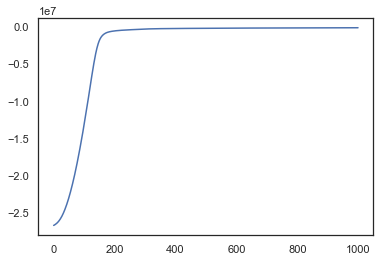

In [65]:
# ELBO
plt.plot(logf)

In [66]:
print_summary(m4, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,3.0220183888531444
SVGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,3.7799260485549473
SVGP.inducing_variable.Z,Parameter,Identity,,True,"(15, 5)",float64,"[[-1.95549677, 2.90239027, -0.43215177..."
SVGP.q_mu,Parameter,Identity,,True,"(15, 1)",float64,[[2.28356393...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 15, 15)",float64,"[[[1.05719289e-01, 0.00000000e+00, 0.00000000e+00..."


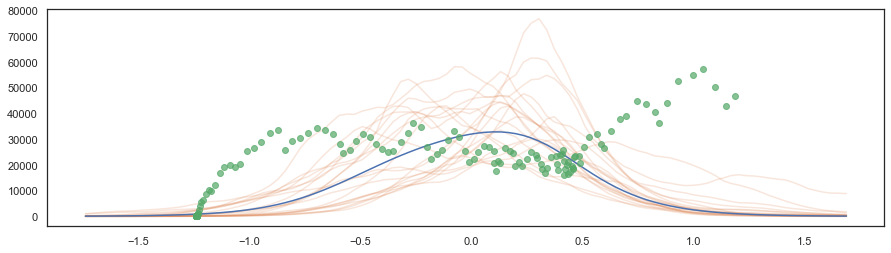

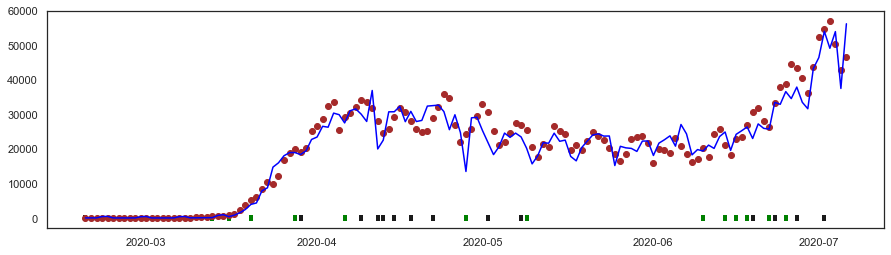

In [67]:
mean, var = m4.predict_f(X_train)
plot_prediction(X_train, y_train, m4, intg=0, X_test=None, Y_test=None, num_samples=20)
plot_model(y_train, np.exp(mean), np.exp(var), intial_inducing_points=list(Zinit[:,0]), inducing_points_list=list(m4.inducing_variable.Z.numpy()[:,0]))

In [68]:
np.mean(var.numpy())

0.29989774348383075

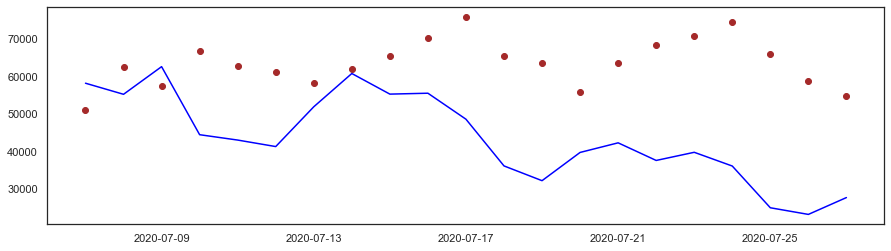

In [69]:
# The test US data are

mean_test, var_test = m4.predict_f(X_test)

plot_model(y_test, np.exp(mean_test), np.exp(var_test), test=True)

In [70]:
np.mean(var_test.numpy())

0.4332891795508238

In [71]:
wsRMSE = np.round(np.sqrt(np.mean((y_train - np.exp(mean))**2)), 3)
osRMSE = np.round(np.sqrt(np.mean((y_test - np.exp(mean_test))**2)), 3)
R_sq = r_2(y_train, np.exp(mean))
print("The within-sample (n={0}) RMSE is: {1} and the out-of-sample (n={2}) RMSE is: {3}. The R^2 is: {4}.".format(X_train.shape[0], wsRMSE, X_test.shape[0], osRMSE, R_sq))

The within-sample (n=139) RMSE is: 3585.575 and the out-of-sample (n=21) RMSE is: 24011.783. The R^2 is: 0.91.


In [72]:
# 7-days forecast (set 2020-07-07 to 2020-07-13)
week1f = np.round(np.mean(final_data_us["ConfirmedChange"].to_numpy()[split:split+7] - np.exp(mean_test)[:7]), 0)
# 14 days forecast (set 2020-07-14 to 2020-07-20)
week2f = np.round(np.mean(final_data_us["ConfirmedChange"].to_numpy()[split+7:split+14] - np.exp(mean_test)[7:14]), 0)
# 21 days forecast (set 2020-07-21 to 2020-07-27)
week3f = np.round(np.mean(final_data_us["ConfirmedChange"].to_numpy()[split+14:] - np.exp(mean_test)[14:]), 0)
# Whole forecat (set 2020-07-07 to 2020-07-27)
forecst = np.round(np.mean(final_data_us["ConfirmedChange"].to_numpy()[split:] - np.exp(mean_test)), 0)
# Difference of the forecast as a ratio of the daily cases (whole test set -- 21 days)
diff_ratio = np.round(np.mean((final_data_us["ConfirmedChange"].to_numpy()[split:] - np.exp(mean_test))/final_data_us["ConfirmedChange"].to_numpy()[split:]), 2)

print("The week1 forecast is: {0}, week2 is: {1}, week3 is {2}, whole test set: {3} and ratio {4}.".format(week1f, week2f, week3f, forecst, diff_ratio))

The week1 forecast is: 9017.0, week2 is: 18594.0, week3 is 32107.0, whole test set: 19906.0 and ratio 0.31.


[Back to Top](#top)

## Alternative 2 <a id='M5'></a>

$\lambda(t)$ = exp($f$(S(t)I(t) + WEEKDAY(t) + HOME(t).avrgsmth(7) + WORK(t).avrgsmth(7) + OTHER(t).avrgsmth(7)))

In [73]:
y = final_data_us["ConfirmedChange"].to_numpy()
X = final_data_us[["SI", "WEEKDAY", "HOME", "WORK", "OTHER"]].copy()
X[["HOME", "WORK", "OTHER"]] = final_data_us[["HOME", "WORK", "OTHER"]].rolling(7).mean().fillna(1)
X = X.to_numpy()


#y = preprocessing.scale(y)
X = preprocessing.scale(X)

split = 139

y_train = y[:split]
y_test = y[split:]

X_train = X[:split]
X_test = X[split:]

y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))

c:\programdata\anaconda3\envs\hyperion\lib\site-packages\sklearn\preprocessing\_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [74]:
MTRN = gpflow.kernels.Matern32()
k = MTRN


print_summary(k, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
Matern32.variance,Parameter,Softplus,,True,(),float64,1
Matern32.lengthscales,Parameter,Softplus,,True,(),float64,1


In [75]:
# Initialise the inducing points
Zinit = inducing_points(X_train, size=15)
Zinit = Zinit.T

In [76]:
m5 = gpflow.models.SVGP(likelihood=gpflow.likelihoods.Poisson(), kernel=k, inducing_variable=Zinit, 
                       num_data=X_train.shape[0])

#natgrad = NaturalGradient(gamma=1.0)
adam = tf.optimizers.Adam(0.01)

#set_trainable(m5.q_mu, False)
#set_trainable(m5.q_sqrt, False)

logf = []

for _ in range(ci_niter(1000)):
    adam.minimize(lambda:m5.training_loss((X_train, y_train)), m5.trainable_variables)
    #natgrad.minimize(lambda:m5.training_loss((X_train, y_train)), [(m5.q_mu, m5.q_sqrt)])   
    logf.append(m5.elbo(((X_train, y_train))))

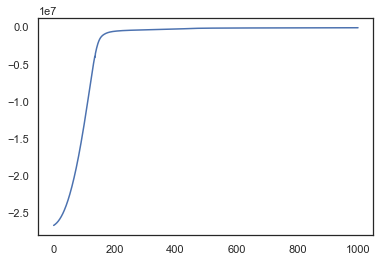

In [77]:
# ELBO
plt.plot(logf)

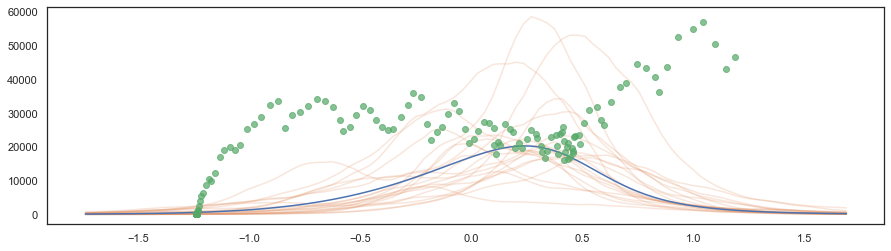

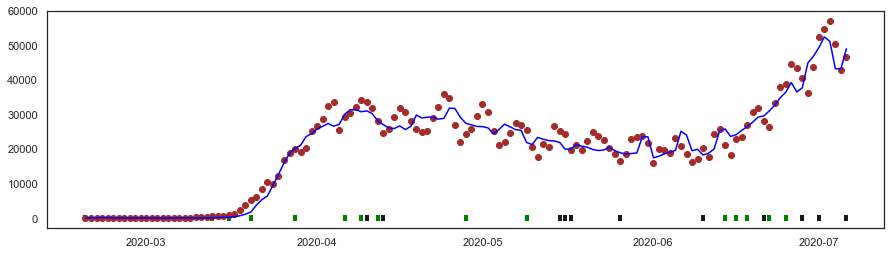

In [78]:
mean, var = m5.predict_f(X_train)
plot_prediction(X_train, y_train, m5, intg=0, X_test=None, Y_test=None, num_samples=20)
plot_model(y_train, np.exp(mean), np.exp(var), intial_inducing_points=list(Zinit[:,0]), inducing_points_list=list(m5.inducing_variable.Z.numpy()[:,0]))

In [79]:
np.mean(var.numpy())

0.28509821695254345

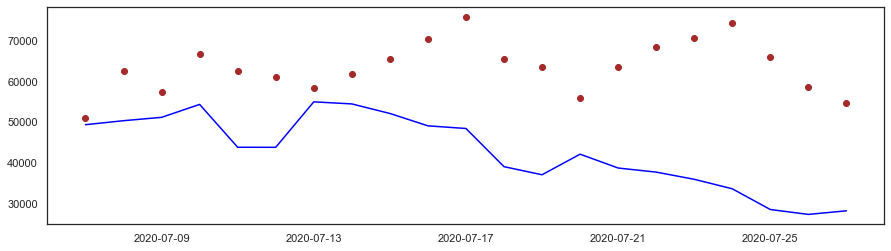

In [80]:
# The test US data are

mean_test, var_test = m5.predict_f(X_test)

plot_model(y_test, np.exp(mean_test), np.exp(var_test), test=True)

In [81]:
np.mean(var_test.numpy())

0.2897545212891427

In [82]:
wsRMSE = np.round(np.sqrt(np.mean((y_train - np.exp(mean))**2)), 3)
osRMSE = np.round(np.sqrt(np.mean((y_test - np.exp(mean_test))**2)), 3)
R_sq = r_2(y_train, np.exp(mean))
print("The within-sample (n={0}) RMSE is: {1} and the out-of-sample (n={2}) RMSE is: {3}. The R^2 is: {4}.".format(X_train.shape[0], wsRMSE, X_test.shape[0], osRMSE, R_sq))

The within-sample (n=139) RMSE is: 3049.507 and the out-of-sample (n=21) RMSE is: 23391.645. The R^2 is: 0.94.


In [83]:
# 7-days forecast (set 2020-07-07 to 2020-07-13)
week1f = np.round(np.mean(final_data_us["ConfirmedChange"].to_numpy()[split:split+7] - np.exp(mean_test)[:7]), 0)
# 14 days forecast (set 2020-07-14 to 2020-07-20)
week2f = np.round(np.mean(final_data_us["ConfirmedChange"].to_numpy()[split+7:split+14] - np.exp(mean_test)[7:14]), 0)
# 21 days forecast (set 2020-07-21 to 2020-07-27)
week3f = np.round(np.mean(final_data_us["ConfirmedChange"].to_numpy()[split+14:] - np.exp(mean_test)[14:]), 0)
# Whole forecat (set 2020-07-07 to 2020-07-27)
forecst = np.round(np.mean(final_data_us["ConfirmedChange"].to_numpy()[split:] - np.exp(mean_test)), 0)
# Difference of the forecast as a ratio of the daily cases (whole test set -- 21 days)
diff_ratio = np.round(np.mean((final_data_us["ConfirmedChange"].to_numpy()[split:] - np.exp(mean_test))/final_data_us["ConfirmedChange"].to_numpy()[split:]), 2)

print("The week1 forecast is: {0}, week2 is: {1}, week3 is {2}, whole test set: {3} and ratio {4}.".format(week1f, week2f, week3f, forecst, diff_ratio))

The week1 forecast is: 10230.0, week2 is: 19376.0, week3 is 32261.0, whole test set: 20622.0 and ratio 0.32.


[Back to Top](#top)

## Alternative Model 2: Test the Effect of Mobility Data  <a id='M6'></a>

$\lambda(t)$ = exp($f$(S(t)I(t) + WKDAY(t) + WORK(t) + OTHER(t)))

In [84]:
y = final_data_us["ConfirmedChange"].to_numpy()
X = final_data_us[["SI", "WEEKDAY", "WORK", "OTHER"]].copy()
X = X.to_numpy()


#y = preprocessing.scale(y)
X = preprocessing.scale(X)

split = 139

y_train = y[:split]
y_test = y[split:]

X_train = X[:split]
X_test = X[split:]

y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))

c:\programdata\anaconda3\envs\hyperion\lib\site-packages\sklearn\preprocessing\_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [85]:
MTRN = gpflow.kernels.Matern32()
k = MTRN

print_summary(k, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
Matern32.variance,Parameter,Softplus,,True,(),float64,1
Matern32.lengthscales,Parameter,Softplus,,True,(),float64,1


In [86]:
# Initialise the inducing points
Zinit = inducing_points(X_train, size=15)
Zinit = Zinit.T

In [87]:
m6 = gpflow.models.SVGP(likelihood=gpflow.likelihoods.Poisson(), kernel=k, inducing_variable=Zinit, 
                       num_data=X_train.shape[0])

adam = tf.optimizers.Adam(0.01)


logf = []

for _ in range(ci_niter(1000)):
    adam.minimize(lambda:m6.training_loss((X_train, y_train)), m6.trainable_variables)
    logf.append(m6.elbo(((X_train, y_train))))

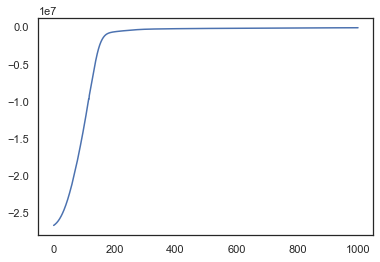

In [88]:
# ELBO
plt.plot(logf)

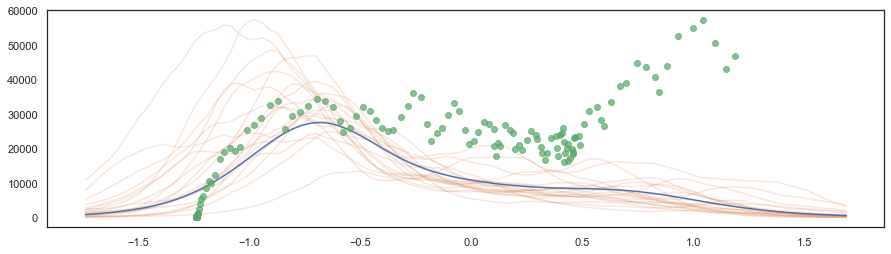

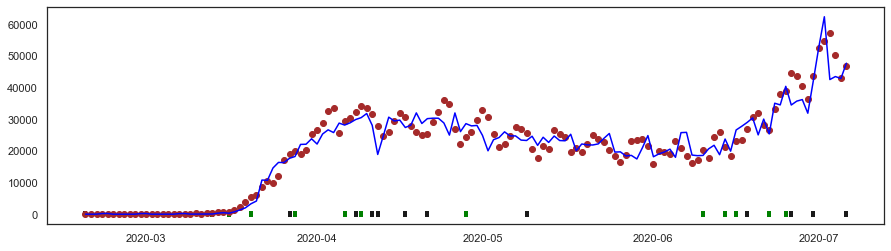

In [89]:
mean, var = m6.predict_f(X_train)
plot_prediction(X_train, y_train, m6, intg=0, X_test=None, Y_test=None, num_samples=20)
plot_model(y_train, np.exp(mean), np.exp(var), intial_inducing_points=list(Zinit[:,0]), inducing_points_list=list(m6.inducing_variable.Z.numpy()[:,0]))

In [90]:
np.mean(var.numpy())

0.196685906567021

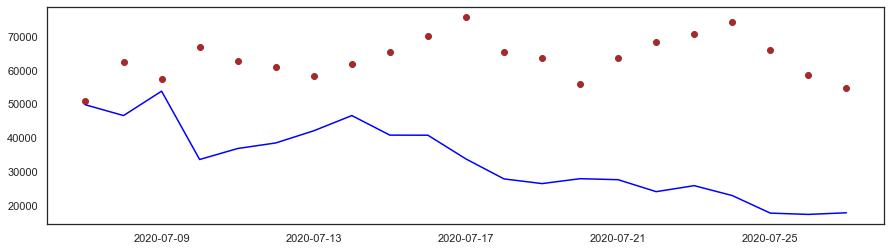

In [91]:
# The test US data are

mean_test, var_test = m6.predict_f(X_test)

plot_model(y_test, np.exp(mean_test), np.exp(var_test), test=True)

In [92]:
np.mean(var_test.numpy())

0.37188877474984366

In [93]:
wsRMSE = np.round(np.sqrt(np.mean((y_train - np.exp(mean))**2)), 3)
osRMSE = np.round(np.sqrt(np.mean((y_test - np.exp(mean_test))**2)), 3)
R_sq = r_2(y_train, np.exp(mean))
print("The within-sample (n={0}) RMSE is: {1} and the out-of-sample (n={2}) RMSE is: {3}. The R^2 is: {4}.".format(X_train.shape[0], wsRMSE, X_test.shape[0], osRMSE, R_sq))

The within-sample (n=139) RMSE is: 3748.607 and the out-of-sample (n=21) RMSE is: 33244.857. The R^2 is: 0.9.


In [94]:
# 7-days forecast (set 2020-07-07 to 2020-07-13)
week1f = np.round(np.mean(final_data_us["ConfirmedChange"].to_numpy()[split:split+7] - np.exp(mean_test)[:7]), 0)
# 14 days forecast (set 2020-07-14 to 2020-07-20)
week2f = np.round(np.mean(final_data_us["ConfirmedChange"].to_numpy()[split+7:split+14] - np.exp(mean_test)[7:14]), 0)
# 21 days forecast (set 2020-07-21 to 2020-07-27)
week3f = np.round(np.mean(final_data_us["ConfirmedChange"].to_numpy()[split+14:] - np.exp(mean_test)[14:]), 0)
# Whole forecat (set 2020-07-07 to 2020-07-27)
forecst = np.round(np.mean(final_data_us["ConfirmedChange"].to_numpy()[split:] - np.exp(mean_test)), 0)
# Difference of the forecast as a ratio of the daily cases (whole test set -- 21 days)
diff_ratio = np.round(np.mean((final_data_us["ConfirmedChange"].to_numpy()[split:] - np.exp(mean_test))/final_data_us["ConfirmedChange"].to_numpy()[split:]), 2)

print("The week1 forecast is: {0}, week2 is: {1}, week3 is {2}, whole test set: {3} and ratio {4}.".format(week1f, week2f, week3f, forecst, diff_ratio))

The week1 forecast is: 16942.0, week2 is: 30611.0, week3 is 43330.0, whole test set: 30294.0 and ratio 0.47.


[Back to Top](#top)

## Model 7: <a id='M7'></a>

$\lambda(t)$ = exp($f$(S(t)I(t) + WKDAY(t) + HOME(t)))

In [95]:
y = final_data_us["ConfirmedChange"].to_numpy()
X = final_data_us[["SI", "WEEKDAY", "HOME"]].copy()
X = X.to_numpy()


#y = preprocessing.scale(y)
X = preprocessing.scale(X)

split = 139

y_train = y[:split]
y_test = y[split:]

X_train = X[:split]
X_test = X[split:]

y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))

c:\programdata\anaconda3\envs\hyperion\lib\site-packages\sklearn\preprocessing\_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [96]:
MTRN = gpflow.kernels.Matern32()
k = MTRN


print_summary(k, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
Matern32.variance,Parameter,Softplus,,True,(),float64,1
Matern32.lengthscales,Parameter,Softplus,,True,(),float64,1


In [97]:
# Initialise the inducing points
Zinit = inducing_points(X_train, size=15)
Zinit = Zinit.T

In [98]:
m7 = gpflow.models.SVGP(likelihood=gpflow.likelihoods.Poisson(), kernel=k, inducing_variable=Zinit, 
                       num_data=X_train.shape[0])

adam = tf.optimizers.Adam(0.01)


logf = []

for _ in range(ci_niter(1000)):
    adam.minimize(lambda:m7.training_loss((X_train, y_train)), m7.trainable_variables) 
    logf.append(m7.elbo(((X_train, y_train))))

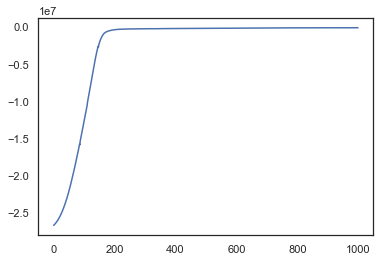

In [99]:
# ELBO
plt.plot(logf)

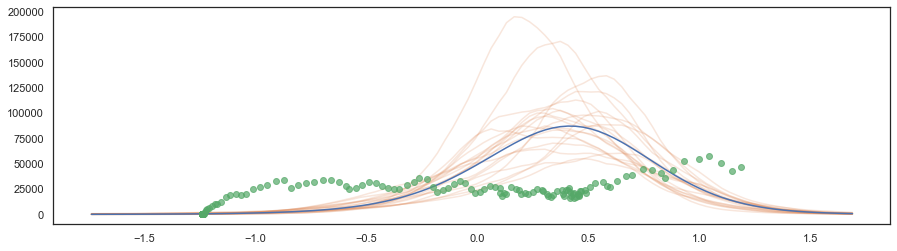

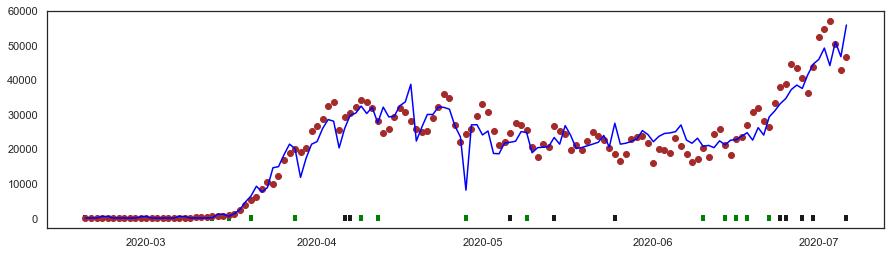

In [100]:
mean, var = m7.predict_f(X_train)
plot_prediction(X_train, y_train, m7, intg=0, X_test=None, Y_test=None, num_samples=20)
plot_model(y_train, np.exp(mean), np.exp(var), intial_inducing_points=list(Zinit[:,0]), inducing_points_list=list(m7.inducing_variable.Z.numpy()[:,0]))

In [101]:
np.mean(var_test.numpy())

0.37188877474984366

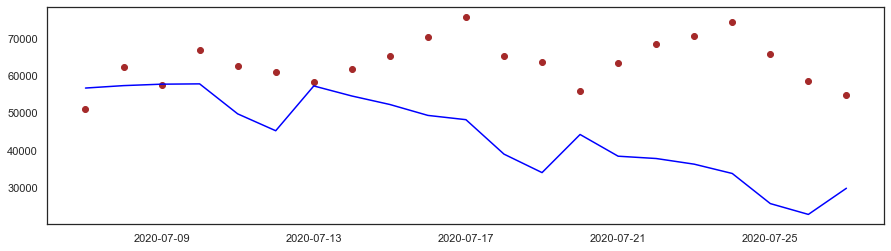

In [102]:
mean_test, var_test = m7.predict_f(X_test)

plot_model(y_test, np.exp(mean_test), np.exp(var_test), test=True)

In [103]:
np.mean(var_test.numpy())

0.2621321670897672

In [104]:
wsRMSE = np.round(np.sqrt(np.mean((y_train - np.exp(mean))**2)), 3)
osRMSE = np.round(np.sqrt(np.mean((y_test - np.exp(mean_test))**2)), 3)
R_sq = r_2(y_train, np.exp(mean))
print("The within-sample (n={0}) RMSE is: {1} and the out-of-sample (n={2}) RMSE is: {3}. The R^2 is: {4}.".format(X_train.shape[0], wsRMSE, X_test.shape[0], osRMSE, R_sq))

The within-sample (n=139) RMSE is: 3904.223 and the out-of-sample (n=21) RMSE is: 23517.157. The R^2 is: 0.91.


In [105]:
# 7-days forecast (set 2020-07-07 to 2020-07-13)
week1f = np.round(np.mean(final_data_us["ConfirmedChange"].to_numpy()[split:split+7] - np.exp(mean_test)[:7]), 0)
# 14 days forecast (set 2020-07-14 to 2020-07-20)
week2f = np.round(np.mean(final_data_us["ConfirmedChange"].to_numpy()[split+7:split+14] - np.exp(mean_test)[7:14]), 0)
# 21 days forecast (set 2020-07-21 to 2020-07-27)
week3f = np.round(np.mean(final_data_us["ConfirmedChange"].to_numpy()[split+14:] - np.exp(mean_test)[14:]), 0)
# Whole forecat (set 2020-07-07 to 2020-07-27)
forecst = np.round(np.mean(final_data_us["ConfirmedChange"].to_numpy()[split:] - np.exp(mean_test)), 0)
# Difference of the forecast as a ratio of the daily cases (whole test set -- 21 days)
diff_ratio = np.round(np.mean((final_data_us["ConfirmedChange"].to_numpy()[split:] - np.exp(mean_test))/final_data_us["ConfirmedChange"].to_numpy()[split:]), 2)

print("The week1 forecast is: {0}, week2 is: {1}, week3 is {2}, whole test set: {3} and ratio {4}.".format(week1f, week2f, week3f, forecst, diff_ratio))

The week1 forecast is: 5383.0, week2 is: 19504.0, week3 is 33109.0, whole test set: 19332.0 and ratio 0.3.


[Back to Top](#top)

## Model 10: <a id='M10'></a>

$\gamma(t)$ = $f$(I(t) + WKDAY(t) + HOME(t))

In [137]:
y = final_data_us["RecoveredChange"].to_numpy()
X = final_data_us[["I", "WEEKDAY", "HOME"]].copy()
X = X.to_numpy()


#y = preprocessing.scale(y)
X = preprocessing.scale(X)

#y = y.clip(-2, 0.2)

split = 139

y_train = y[:split]
y_test = y[split:]

X_train = X[:split]
X_test = X[split:]

y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))

In [138]:
MTRN = gpflow.kernels.Matern32()
k = MTRN


print_summary(k, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
Matern32.variance,Parameter,Softplus,,True,(),float64,1
Matern32.lengthscales,Parameter,Softplus,,True,(),float64,1


In [139]:
# Initialise the inducing points
Zinit = inducing_points(X_train, size=15)
Zinit = Zinit.T

In [140]:
m10 = gpflow.models.SVGP(likelihood=gpflow.likelihoods.Poisson(), kernel=k, inducing_variable=Zinit, 
                       num_data=X_train.shape[0])

#natgrad = NaturalGradient(gamma=1.0)
adam = tf.optimizers.Adam(0.01)

#set_trainable(m10.q_mu, False)
#set_trainable(m10.q_sqrt, False)

logf = []

for _ in range(ci_niter(1000)):
    adam.minimize(lambda:m10.training_loss((X_train, y_train)), m10.trainable_variables)
    #natgrad.minimize(lambda:m10.training_loss((X_train, y_train)), [(m10.q_mu, m10.q_sqrt)])   
    logf.append(m10.elbo(((X_train, y_train))))

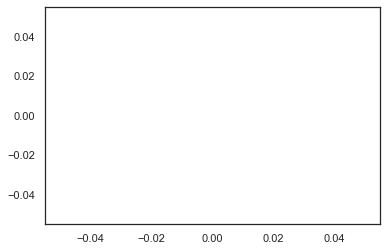

In [141]:
# ELBO
plt.plot(logf)

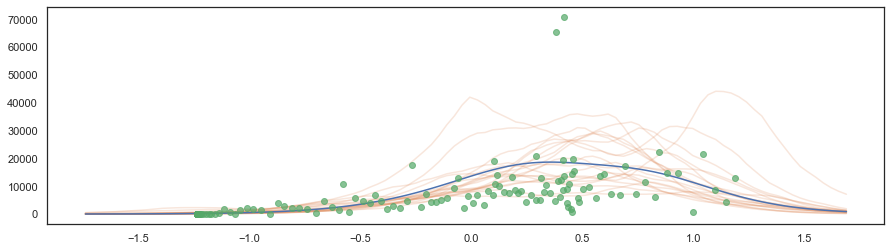

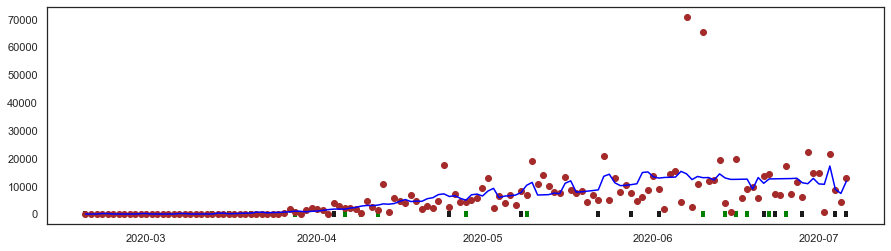

In [142]:
mean, var = m10.predict_f(X_train)
plot_prediction(X_train, y_train, m10, intg=0, X_test=None, Y_test=None, num_samples=20)
plot_model(y_train, np.exp(mean), np.exp(var), intial_inducing_points=list(Zinit[:,0]), inducing_points_list=list(m10.inducing_variable.Z.numpy()[:,0]))

In [143]:
np.mean(var.numpy())

0.12220634548564094

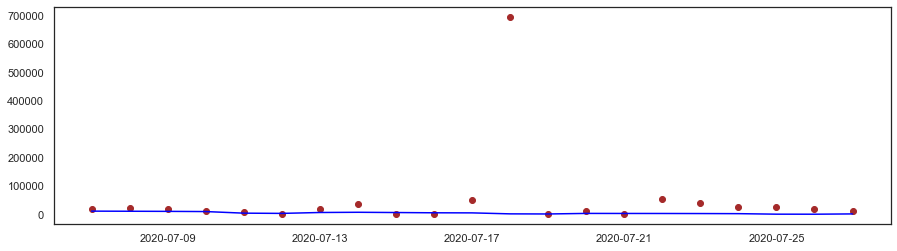

In [144]:
mean_test, var_test = m10.predict_f(X_test)

plot_model(y_test, np.exp(mean_test), np.exp(var_test), test=True)

In [145]:
np.mean(var_test.numpy())

0.5780977876448982

In [146]:
wsRMSE = np.round(np.sqrt(np.mean((y_train - np.exp(mean))**2)), 3)
osRMSE = np.round(np.sqrt(np.mean((y_test - np.exp(mean_test))**2)), 3)
R_sq = r_2(y_train, np.exp(mean))
print("The within-sample (n={0}) RMSE is: {1} and the out-of-sample (n={2}) RMSE is: {3}. The R^2 is: {4}.".format(X_train.shape[0], wsRMSE, X_test.shape[0], osRMSE, R_sq))

The within-sample (n=139) RMSE is: 7581.406 and the out-of-sample (n=21) RMSE is: 152663.2. The R^2 is: 0.31.


In [147]:
# 7-days forecast (set 2020-07-07 to 2020-07-13)
week1f = np.round(np.mean(final_data_us["ConfirmedChange"].to_numpy()[split:split+7] - np.exp(mean_test)[:7]), 0)
# 14 days forecast (set 2020-07-14 to 2020-07-20)
week2f = np.round(np.mean(final_data_us["ConfirmedChange"].to_numpy()[split+7:split+14] - np.exp(mean_test)[7:14]), 0)
# 21 days forecast (set 2020-07-21 to 2020-07-27)
week3f = np.round(np.mean(final_data_us["ConfirmedChange"].to_numpy()[split+14:] - np.exp(mean_test)[14:]), 0)
# Whole forecat (set 2020-07-07 to 2020-07-27)
forecst = np.round(np.mean(final_data_us["ConfirmedChange"].to_numpy()[split:] - np.exp(mean_test)), 0)
# Difference of the forecast as a ratio of the daily cases (whole test set -- 21 days)
diff_ratio = np.round(np.mean((final_data_us["ConfirmedChange"].to_numpy()[split:] - np.exp(mean_test))/final_data_us["ConfirmedChange"].to_numpy()[split:]), 2)

print("The week1 forecast is: {0}, week2 is: {1}, week3 is {2}, whole test set: {3} and ratio {4}.".format(week1f, week2f, week3f, forecst, diff_ratio))

The week1 forecast is: 51620.0, week2 is: 60839.0, week3 is 62944.0, whole test set: 58468.0 and ratio 0.92.


[Back to Top](#top)

## Model 11: <a id='M11'></a>

$\gamma(t)$ = $f$(I(t) + WKDAY(t) + WORK(t) + OTHER(t))

In [ ]:
y = final_data_us["RecoveredChange"].to_numpy()
X = final_data_us[["I", "WEEKDAY", "WORK", "OTHER"]].copy()
X = X.to_numpy()


y = preprocessing.scale(y)
X = preprocessing.scale(X)

split = 139

y_train = y[:split]
y_test = y[split:]

X_train = X[:split]
X_test = X[split:]

y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))

In [ ]:
MTRN = gpflow.kernels.Matern32()
k = MTRN

SE = gpflow.kernels.SquaredExponential()
LIN = gpflow.kernels.Linear()
RQ = gpflow.kernels.RationalQuadratic()
k = SE*LIN*RQ

print_summary(k, fmt="notebook")

In [ ]:
# Initialise the inducing points
Zinit = inducing_points(X_train, size=15)
Zinit = Zinit.T

In [ ]:
m10 = gpflow.models.SVGP(likelihood=gpflow.likelihoods.Gaussian(), kernel=k, inducing_variable=Zinit, 
                       num_data=X_train.shape[0])

natgrad = NaturalGradient(gamma=1.0)
adam = tf.optimizers.Adam(0.01)

set_trainable(m10.q_mu, False)
set_trainable(m10.q_sqrt, False)

logf = []

for _ in range(ci_niter(1000)):
    adam.minimize(lambda:m10.training_loss((X_train, y_train)), m10.trainable_variables)
    natgrad.minimize(lambda:m10.training_loss((X_train, y_train)), [(m10.q_mu, m10.q_sqrt)])   
    logf.append(m10.elbo(((X_train, y_train))))

In [ ]:
# ELBO
plt.plot(logf)

In [ ]:
mean, var = m10.predict_f(X_train)
plot_prediction(X_train, y_train, m10, intg=0, X_test=None, Y_test=None, num_samples=20)
plot_model(y_train, mean, var, intial_inducing_points=list(Zinit[:,0]), inducing_points_list=list(m10.inducing_variable.Z.numpy()[:,0]))

In [ ]:
np.mean(var.numpy())

In [ ]:
mean_test, var_test = m10.predict_f(X_test)

plot_model(y_test, mean_test, var_test, test=True)

In [ ]:
np.mean(var_test.numpy())

In [ ]:
wsRMSE = np.round(np.sqrt(np.mean((y_train - mean.numpy())**2)), 3)
osRMSE = np.round(np.sqrt(np.mean((y_test - mean_test.numpy())**2)), 3)
R_sq = r_2(y_train, mean.numpy())
print("The within-sample (n={0}) RMSE is: {1} and the out-of-sample (n={2}) RMSE is: {3}. The R^2 is: {4}.".format(X_train.shape[0], wsRMSE, X_test.shape[0], osRMSE, R_sq))

In [ ]:
# 7-days forecast (set 2020-07-07 to 2020-07-13)
week1f = np.round(np.mean(final_data_us["RecoveredChange"].to_numpy()[split:split+7] - (mean_test.numpy()[:7]*std_rcap + mean_rcap)), 0)
# 14 days forecast (set 2020-07-14 to 2020-07-20)
week2f = np.round(np.mean(final_data_us["RecoveredChange"].to_numpy()[split+7:split+14] - (mean_test.numpy()[7:14]*std_rcap + mean_rcap)), 0)
# 21 days forecast (set 2020-07-21 to 2020-07-27)
week3f = np.round(np.mean(final_data_us["RecoveredChange"].to_numpy()[split+14:] - (mean_test.numpy()[14:]*std_rcap + mean_rcap)), 0)
# Whole forecat (set 2020-07-07 to 2020-07-27)
forecst = np.round(np.mean(final_data_us["RecoveredChange"].to_numpy()[split:] - (mean_test.numpy()*std_rcap + mean_rcap)), 0)
# Difference of the forecast as a ratio of the daily cases (whole test set -- 21 days)
diff_ratio = np.round(np.mean((final_data_us["RecoveredChange"].to_numpy()[split:] - (mean_test.numpy()*std_rcap + mean_rcap))/(final_data_us["RecoveredChange"].to_numpy()[split:] + 0.001)), 2)

print("The week1 forecast is: {0}, week2 is: {1}, week3 is {2}, whole test set: {3} and ratio {4}.".format(week1f, week2f, week3f, forecst, diff_ratio))

[Back to Top](#top)

## Model 12:

$\gamma(t)$ = $f$(S(t)I(t) + WKDAY(t) + WORK(t) + OTHER(t))

In [ ]:
y = final_data_us["RecoveredChange"].to_numpy()
X = final_data_us[["SI", "WEEKDAY", "HOME"]].copy()
X = X.to_numpy()


y = preprocessing.scale(y)
X = preprocessing.scale(X)

split = 139

y_train = y[:split]
y_test = y[split:]

X_train = X[:split]
X_test = X[split:]

y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))

In [ ]:
MTRN = gpflow.kernels.Matern32()
k = MTRN

SE = gpflow.kernels.SquaredExponential()
LIN = gpflow.kernels.Linear()
RQ = gpflow.kernels.RationalQuadratic()
k = SE*LIN*RQ

print_summary(k, fmt="notebook")

In [ ]:
# Initialise the inducing points
Zinit = inducing_points(X_train, size=15)
Zinit = Zinit.T

In [ ]:
m9 = gpflow.models.SVGP(likelihood=gpflow.likelihoods.Gaussian(), kernel=k, inducing_variable=Zinit, 
                       num_data=X_train.shape[0])

natgrad = NaturalGradient(gamma=1.0)
adam = tf.optimizers.Adam(0.01)

set_trainable(m9.q_mu, False)
set_trainable(m9.q_sqrt, False)

logf = []

for _ in range(ci_niter(1000)):
    adam.minimize(lambda:m9.training_loss((X_train, y_train)), m9.trainable_variables)
    natgrad.minimize(lambda:m9.training_loss((X_train, y_train)), [(m9.q_mu, m9.q_sqrt)])   
    logf.append(m9.elbo(((X_train, y_train))))

In [ ]:
# ELBO
plt.plot(logf)

In [ ]:
mean, var = m9.predict_f(X_train)
plot_prediction(X_train, y_train, m9, intg=0, X_test=None, Y_test=None, num_samples=20)
plot_model(y_train, mean, var, intial_inducing_points=list(Zinit[:,1]), inducing_points_list=list(m9.inducing_variable.Z.numpy()[:,1]), x_ind=1)

In [ ]:
np.mean(var.numpy())

In [ ]:
# The test US data are

mean_test, var_test = m9.predict_f(X_test)

plot_model(y_test, mean_test, var_test, test=True)

In [ ]:
np.mean(var_test.numpy())

In [ ]:
wsRMSE = np.round(np.sqrt(np.mean((y_train - mean.numpy())**2)), 3)
osRMSE = np.round(np.sqrt(np.mean((y_test - mean_test.numpy())**2)), 3)
R_sq = r_2(y_train, mean.numpy())
print("The within-sample (n={0}) RMSE is: {1} and the out-of-sample (n={2}) RMSE is: {3}. The R^2 is: {4}.".format(X_train.shape[0], wsRMSE, X_test.shape[0], osRMSE, R_sq))

In [ ]:
# 7-days forecast (set 2020-07-07 to 2020-07-13)
week1f = np.round(np.mean(final_data_us["ConfirmedChange"].to_numpy()[split:split+7] - (mean_test.numpy()[:7]*std_y + mean_y)), 0)
# 14 days forecast (set 2020-07-14 to 2020-07-20)
week2f = np.round(np.mean(final_data_us["ConfirmedChange"].to_numpy()[split+7:split+14] - (mean_test.numpy()[7:14]*std_y + mean_y)), 0)
# 21 days forecast (set 2020-07-21 to 2020-07-27)
week3f = np.round(np.mean(final_data_us["ConfirmedChange"].to_numpy()[split+14:] - (mean_test.numpy()[14:]*std_y + mean_y)), 0)
# Whole forecat (set 2020-07-07 to 2020-07-27)
forecst = np.round(np.mean(final_data_us["ConfirmedChange"].to_numpy()[split:] - (mean_test.numpy()*std_y + mean_y)), 0)
# Difference of the forecast as a ratio of the daily cases (whole test set -- 21 days)
diff_ratio = np.round(np.mean((final_data_us["ConfirmedChange"].to_numpy()[split:] - (mean_test.numpy()*std_y + mean_y))/final_data_us["ConfirmedChange"].to_numpy()[split:]), 2)

print("The week1 forecast is: {0}, week2 is: {1}, week3 is {2}, whole test set: {3} and ratio {4}.".format(week1f, week2f, week3f, forecst, diff_ratio))

[Back to Top](#top)

## Model 9: <a id='M9'></a>

$\lambda(t)$ = exp($f$(WKDAY(t) + HOME(t) + WORK(t) + OTHER(t)))

In [126]:
y = final_data_us["ConfirmedChange"].to_numpy()
X = final_data_us[["WEEKDAY", "HOME", "WORK", "OTHER"]].copy()
X = X.to_numpy()


#y = preprocessing.scale(y)
X = preprocessing.scale(X)

split = 139

y_train = y[:split]
y_test = y[split:]

X_train = X[:split]
X_test = X[split:]

y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))

In [127]:
MTRN = gpflow.kernels.Matern32()
k = MTRN


print_summary(k, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
Matern32.variance,Parameter,Softplus,,True,(),float64,1
Matern32.lengthscales,Parameter,Softplus,,True,(),float64,1


In [128]:
# Initialise the inducing points
Zinit = inducing_points(X_train, size=15)
Zinit = Zinit.T

In [129]:
m9 = gpflow.models.SVGP(likelihood=gpflow.likelihoods.Poisson(), kernel=k, inducing_variable=Zinit, 
                       num_data=X_train.shape[0])

#natgrad = NaturalGradient(gamma=1.0)
adam = tf.optimizers.Adam(0.01)

#set_trainable(m9.q_mu, False)
#set_trainable(m9.q_sqrt, False)

logf = []

for _ in range(ci_niter(1000)):
    adam.minimize(lambda:m9.training_loss((X_train, y_train)), m9.trainable_variables)
    #natgrad.minimize(lambda:m9.training_loss((X_train, y_train)), [(m9.q_mu, m9.q_sqrt)])   
    logf.append(m9.elbo(((X_train, y_train))))

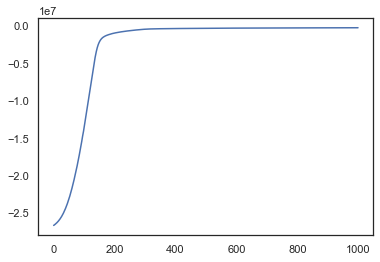

In [130]:
# ELBO
plt.plot(logf)

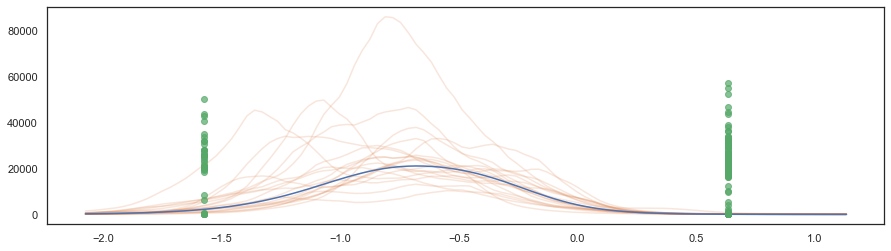

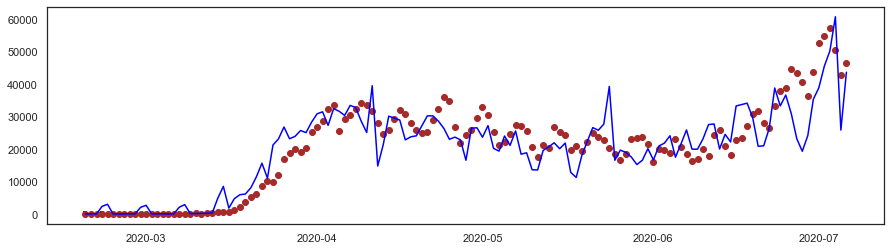

In [131]:
mean, var = m9.predict_f(X_train)
plot_prediction(X_train, y_train, m9, intg=0, X_test=None, Y_test=None, num_samples=20)
plot_model(y_train, np.exp(mean), np.exp(var), intial_inducing_points=list(Zinit[:,0]), inducing_points_list=list(m9.inducing_variable.Z.numpy()[:,0]))

In [132]:
np.mean(var.numpy())

0.1988289474281774

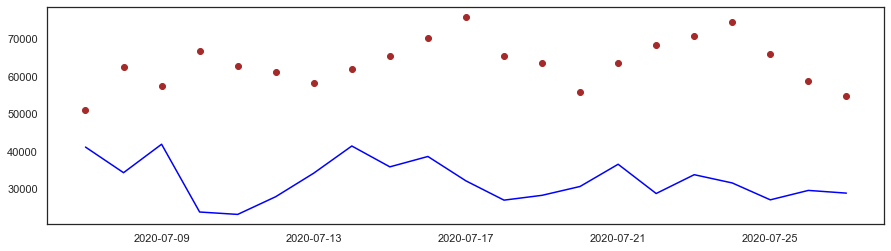

In [133]:
# The test US data are

mean_test, var_test = m9.predict_f(X_test)

plot_model(y_test, np.exp(mean_test), np.exp(var_test), test=True)

In [134]:
np.mean(var_test.numpy())

0.017206996328943874

In [135]:
wsRMSE = np.round(np.sqrt(np.mean((y_train - np.exp(mean))**2)), 3)
osRMSE = np.round(np.sqrt(np.mean((y_test - np.exp(mean_test))**2)), 3)
R_sq = r_2(y_train, np.exp(mean))
print("The within-sample (n={0}) RMSE is: {1} and the out-of-sample (n={2}) RMSE is: {3}. The R^2 is: {4}.".format(X_train.shape[0], wsRMSE, X_test.shape[0], osRMSE, R_sq))

The within-sample (n=139) RMSE is: 6297.614 and the out-of-sample (n=21) RMSE is: 32505.152. The R^2 is: 0.8.


In [136]:
# 7-days forecast (set 2020-07-07 to 2020-07-13)
week1f = np.round(np.mean(final_data_us["ConfirmedChange"].to_numpy()[split:split+7] - np.exp(mean_test)[:7]), 0)
# 14 days forecast (set 2020-07-14 to 2020-07-20)
week2f = np.round(np.mean(final_data_us["ConfirmedChange"].to_numpy()[split+7:split+14] - np.exp(mean_test)[7:14]), 0)
# 21 days forecast (set 2020-07-21 to 2020-07-27)
week3f = np.round(np.mean(final_data_us["ConfirmedChange"].to_numpy()[split+14:] - np.exp(mean_test)[14:]), 0)
# Whole forecat (set 2020-07-07 to 2020-07-27)
forecst = np.round(np.mean(final_data_us["ConfirmedChange"].to_numpy()[split:] - np.exp(mean_test)), 0)
# Difference of the forecast as a ratio of the daily cases (whole test set -- 21 days)
diff_ratio = np.round(np.mean((final_data_us["ConfirmedChange"].to_numpy()[split:] - np.exp(mean_test))/final_data_us["ConfirmedChange"].to_numpy()[split:]), 2)

print("The week1 forecast is: {0}, week2 is: {1}, week3 is {2}, whole test set: {3} and ratio {4}.".format(week1f, week2f, week3f, forecst, diff_ratio))

The week1 forecast is: 27515.0, week2 is: 31964.0, week3 is 34235.0, whole test set: 31238.0 and ratio 0.49.


[Back to Top](#top)

## Alternative Model 3: Multioutput <a id='M8'></a>

\begin{align*}
\dot{S} & =  - \beta \frac{SI}{N} \\
\dot{I}  & =  \beta \frac{SI}{N} - \gamma I  \\
\dot{R}  & =  \gamma I 
\end{align*}

$\lambda(t), \gamma(t)$ = $f$($X\delta(t)$) = $Wg$(S(t)I(t) + WKDAY(t) + WORK(t) + OTHER(t), I(t) + WKDAY(t) + HOME(t))

In [ ]:
y = final_data_us[["ConfirmedChange", "RecoveredChange"]].to_numpy()
X = final_data_us[["SI", "I", "WEEKDAY", "HOME", "WORK", "OTHER"]].to_numpy()


y = preprocessing.scale(y)
X = preprocessing.scale(X)

split = 139

y_train = y[:split]
y_test = y[split:]

X_train = X[:split]
X_test = X[split:]

In [ ]:
print("The Y dimensions are {0} rows and {1} columns; the X dimensions are {2} rows and {3} columns.".format(y.shape[0], y.shape[1], X.shape[0], X.shape[1]))

In [ ]:
SE = gpflow.kernels.SquaredExponential(active_dims=[0, 2, 4, 5])
LIN = gpflow.kernels.Linear(active_dims=[0, 2, 4, 5])
RQ = gpflow.kernels.RationalQuadratic(active_dims=[0, 2, 4, 5])
k1 = SE * LIN * RQ

SE = gpflow.kernels.SquaredExponential(active_dims=[1, 2, 3])
LIN = gpflow.kernels.Linear(active_dims=[1, 2, 3])
RQ = gpflow.kernels.RationalQuadratic(active_dims=[1, 2, 3])
k2 = SE * LIN * RQ

# Create list of kernels for each output
kern_list = [k1, k2]
# Create multi-output kernel from kernel list
kernel = gpflow.kernels.SeparateIndependent(kern_list)

print_summary(kernel, fmt='notebook')

In [ ]:
# Initialise the inducing points
Zinit = inducing_points(X_train, size=15)
Zinit = Zinit.T

# initialization of inducing input locations, one set of locations per output
Zs = [Zinit.copy() for _ in range(y_train.shape[1])]
# initialize as list inducing inducing variables
iv_list = [gpflow.inducing_variables.InducingPoints(Z) for Z in Zs]
# create multi-output inducing variables from iv_list
iv = gpflow.inducing_variables.SeparateIndependentInducingVariables(iv_list)

In [ ]:
m8 = gpflow.models.SVGP(likelihood=gpflow.likelihoods.Gaussian(), kernel=kernel, inducing_variable=iv, 
                       num_data=X_train.shape[0], num_latent_gps=y_train.shape[1])

natgrad = NaturalGradient(gamma=1.0)
adam = tf.optimizers.Adam(0.01)

set_trainable(m8.q_mu, False)
set_trainable(m8.q_sqrt, False)

logf = []

for _ in range(ci_niter(1000)):
    adam.minimize(lambda:m8.training_loss((X_train, y_train)), m8.trainable_variables)
    natgrad.minimize(lambda:m8.training_loss((X_train, y_train)), [(m8.q_mu, m8.q_sqrt)])   
    logf.append(m8.elbo(((X_train, y_train))))

In [ ]:
print_summary(m8, fmt='notebook')

In [ ]:
# ELBO
plt.plot(logf)

In [ ]:
mean, var = m8.predict_f(X_train)

#plot_model(y_train, mean, var, intial_inducing_points=list(Zinit[:,0]), inducing_points_list=list(m.inducing_variable.Z.numpy()[:,0]))

In [ ]:
plot_model(y_train[:,0], mean[:,0], var[:,0], intial_inducing_points=list(Zinit[:,0]), inducing_points_list=list(m8.inducing_variable.inducing_variable_list[0].Z.numpy()[:,0]))

In [ ]:
plot_model(y_train[:,1], mean[:,1], var[:,1], intial_inducing_points=list(Zinit[:,1]), inducing_points_list=list(m8.inducing_variable.inducing_variable_list[1].Z.numpy()[:,1]))

In [ ]:
np.mean(var.numpy(), axis=0)

In [ ]:
# The test US data are

mean_test, var_test = m8.predict_f(X_test)

plot_model(y_test[:,0], mean_test[:,0], var_test[:,0], test=True)
plot_model(y_test[:,1], mean_test[:,1], var_test[:,1], test=True)

In [ ]:
np.mean(var_test.numpy(), axis=0)

In [ ]:
wsRMSE = np.round(np.sqrt(np.mean((y_train[:, 0] - mean.numpy()[:, 0])**2)), 3)
osRMSE = np.round(np.sqrt(np.mean((y_test[:, 0] - mean_test.numpy()[:, 0])**2)), 3)
R_sq = r_2(y_train[:, 0], mean.numpy()[:, 0])
print("The within-sample (n={0}) RMSE is: {1} and the out-of-sample (n={2}) RMSE is: {3}. The R^2 is: {4}.".format(X_train.shape[0], wsRMSE, X_test.shape[0], osRMSE, R_sq))

In [ ]:
wsRMSE = np.round(np.sqrt(np.mean((y_train[:, 1] - mean.numpy()[:, 1])**2)), 3)
osRMSE = np.round(np.sqrt(np.mean((y_test[:, 1] - mean_test.numpy()[:, 1])**2)), 3)
R_sq = r_2(y_train[:, 1], mean.numpy()[:, 1])
print("The within-sample (n={0}) RMSE is: {1} and the out-of-sample (n={2}) RMSE is: {3}. The R^2 is: {4}.".format(X_train.shape[0], wsRMSE, X_test.shape[0], osRMSE, R_sq))

In [ ]:
plt.figure(figsize=(15, 4))
plt.plot(final_data_us.loc[split:, "Updated"], X_test[:,3], label="HOME")
plt.plot(final_data_us.loc[split:, "Updated"], X_test[:,1], label="I")
plt.plot(final_data_us.loc[split:, "Updated"], y_test[:,1], label="Recovered")
plt.legend(loc='upper left')

In [ ]:
# 7-days forecast (set 2020-07-07 to 2020-07-13)
week1f = np.round(np.mean(final_data_us["ConfirmedChange"].to_numpy()[split:split+7] - (mean_test.numpy()[:7, 0]*std_y + mean_y)), 0)
# 14 days forecast (set 2020-07-14 to 2020-07-20)
week2f = np.round(np.mean(final_data_us["ConfirmedChange"].to_numpy()[split+7:split+14] - (mean_test.numpy()[7:14, 0]*std_y + mean_y)), 0)
# 21 days forecast (set 2020-07-21 to 2020-07-27)
week3f = np.round(np.mean(final_data_us["ConfirmedChange"].to_numpy()[split+14:] - (mean_test.numpy()[14:, 0]*std_y + mean_y)), 0)
# Whole forecat (set 2020-07-07 to 2020-07-27)
forecst = np.round(np.mean(final_data_us["ConfirmedChange"].to_numpy()[split:] - (mean_test.numpy()[:, 0]*std_y + mean_y)), 0)
# Difference of the forecast as a ratio of the daily cases (whole test set -- 21 days)
diff_ratio = np.round(np.mean((final_data_us["ConfirmedChange"].to_numpy()[split:] - (mean_test.numpy()[:, 0]*std_y + mean_y))/final_data_us["ConfirmedChange"].to_numpy()[split:]), 2)

print("The week1 forecast is: {0}, week2 is: {1}, week3 is {2}, whole test set: {3} and ratio {4}.".format(week1f, week2f, week3f, forecst, diff_ratio))

In [ ]:
# 7-days forecast (set 2020-07-07 to 2020-07-13)
week1f = np.round(np.mean(final_data_us["RecoveredChange"].to_numpy()[split:split+7] - (mean_test.numpy()[:7, 1]*std_r + mean_r)), 0)
# 14 days forecast (set 2020-07-14 to 2020-07-20)
week2f = np.round(np.mean(final_data_us["RecoveredChange"].to_numpy()[split+7:split+14] - (mean_test.numpy()[7:14, 1]*std_r + mean_r)), 0)
# 21 days forecast (set 2020-07-21 to 2020-07-27)
week3f = np.round(np.mean(final_data_us["RecoveredChange"].to_numpy()[split+14:] - (mean_test.numpy()[14:, 1]*std_r + mean_r)), 0)
# Whole forecat (set 2020-07-07 to 2020-07-27)
forecst = np.round(np.mean(final_data_us["RecoveredChange"].to_numpy()[split:] - (mean_test.numpy()[:, 1]*std_r + mean_r)), 0)
# Difference of the forecast as a ratio of the daily cases (whole test set -- 21 days)
diff_ratio = np.round(np.mean((final_data_us["RecoveredChange"].to_numpy()[split:] - (mean_test.numpy()[:, 1]*std_r + mean_r))/(final_data_us["RecoveredChange"].to_numpy()[split:]+ 0.0001)), 2)

print("The week1 forecast is: {0}, week2 is: {1}, week3 is {2}, whole test set: {3} and ratio {4}.".format(week1f, week2f, week3f, forecst, diff_ratio))

[Back to Top](#top)